In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from robocop import fetch_events,build_pid_windows,evaluate_and_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [5]:
NUM_SYSCALLS = 473
NGRAM = 4
NU = 0.05
GAMMA = "scale"


In [6]:
encoder = OneHotEncoder(
    categories=[np.arange(NUM_SYSCALLS)] * NGRAM,
)

encoder.fit(np.zeros((1, NGRAM), dtype=np.int32))


,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20","[array([ 0, ...70, 471, 472]), array([ 0, ...70, 471, 472]), ...]"
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",None
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",True
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'error'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:

In [7]:

def extract_features(window, syscall_to_id=None):
    syscalls = [e["syscall_num"] for e in window]
    if len(syscalls) < NGRAM:
        return np.zeros(NUM_SYSCALLS * NGRAM, dtype=np.float32)
    trigrams = np.array(
        [syscalls[i:i+NGRAM] for i in range(len(syscalls) - NGRAM + 1)],
        dtype=np.int32
    )
    onehot = encoder.transform(trigrams)
    return np.asarray(onehot.sum(axis=0)).ravel().astype(np.float32)

def build_X(windows, syscall_to_id=None):
    return np.array([extract_features(w) for w in windows], dtype=np.float32)

In [8]:
# OneHotEncoding Of Ngrams
print(build_X([[{"syscall_num":1},{"syscall_num":4},{"syscall_num":472},{"syscall_num":472}],
               [{"syscall_num":2},{"syscall_num":4},{"syscall_num":2},{"syscall_num":472}]]))

[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]


In [9]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14'",10)

In [10]:
train_events[0]

{'id': 17,
 'ts': 1768424195751936.0,
 'pid': 5720,
 'tid': 6632,
 'syscall_num': 14,
 'process_name': 'em32\\audiodg.exe'}

In [11]:
extract_features(train_events[0:4])

array([0., 0., 0., ..., 0., 0., 0.], shape=(1892,), dtype=float32)

In [12]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14'",1_000_000)

In [14]:
len(train_events)

1000000

In [13]:
train_windows = build_pid_windows(train_events)
X_train = build_X(train_windows)

In [14]:
X_train.shape

(249927, 1892)

In [15]:
def show_pca_as_graph(X):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("X_train projected to 2D using PCA")
    plt.show()

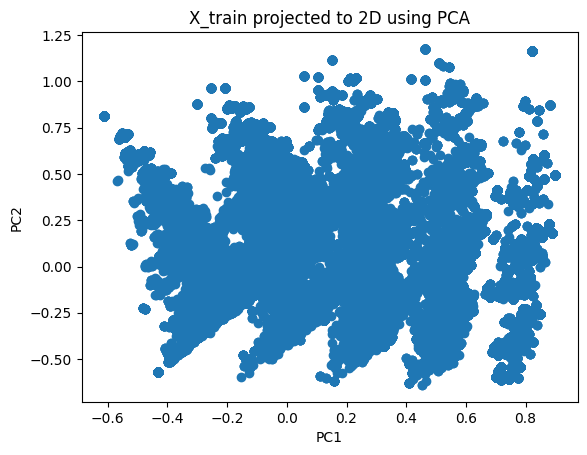

In [16]:
show_pca_as_graph(X_train)

In [17]:
virus_events = fetch_events("test = '10'",10_000)
virus_windows = build_pid_windows(virus_events)
X_virus = build_X(virus_windows)

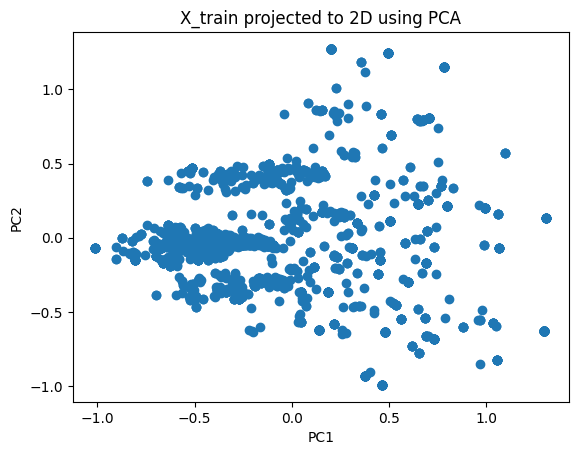

In [18]:
show_pca_as_graph(X_virus)

In [19]:
normal_events = fetch_events("test = '16'",10_000)
normal_windows = build_pid_windows(normal_events)
X_normal = build_X(normal_windows)

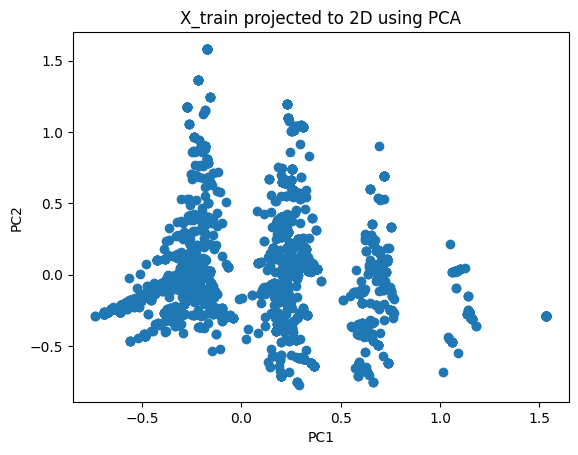

In [20]:
show_pca_as_graph(X_normal)

In [ ]:

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

model = OneClassSVM(kernel="rbf", nu=NU, gamma=0.01)
model.fit(X_train_scaled)

print("[✓] Model trained")

normal_report = evaluate_and_report(
    label="NORMAL",
    windows=normal_windows,
    X=X_normal,
    model=model,
    scaler=scaler
)

virus_report = evaluate_and_report(
    label="VIRUS",
    windows=virus_windows,
    X=X_virus,
    model=model,
    scaler=scaler
)

print("NORMAL:", normal_report)
print("VIRUS:", virus_report)


In [ ]:
len(train_events)